In [ ]:
import os
import io
import string
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tarfile
import requests
from io import BytesIO

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
response = requests.get(url)

with tarfile.open(fileobj=BytesIO(response.content), mode="r:gz") as tar:
    tar.extractall(path="tarextract")

### Read data

In [ ]:
data_dir = "tarextract/aclImdb"

# Function to load reviews from a folder (pos/neg)
def load_reviews(directory, label):
    reviews = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
            reviews.append((file.read(), label))
    return reviews

# Load positive and negative reviews from train and test folders
pos_reviews = load_reviews(os.path.join(data_dir, "train/pos"), 1) + load_reviews(os.path.join(data_dir, "test/pos"), 1)
neg_reviews = load_reviews(os.path.join(data_dir, "train/neg"), 0) + load_reviews(os.path.join(data_dir, "test/neg"), 0)

# Combine into a single dataframe
df = pd.DataFrame(pos_reviews + neg_reviews, columns=["review", "sentiment"])

df.head()  # Preview the dataset

,review,sentiment
0,"I consider this movie a masterpiece, but it to...",1
1,Christina Raines plays a lovely model in New Y...,1
2,I reached the end of this and I was almost sho...,1
3,This is not the typical Mel Brooks film. It wa...,1
4,"I always follow the Dakar, so when my husband ...",1


In [ ]:
# Shuffle the DataFrame
shuffled_data = df.sample(frac=1, random_state=2023)

train_size = 0.8  # 80% for training, 20% for testing
train_data, test_data = train_test_split(shuffled_data, train_size=train_size, random_state=2023)

In [ ]:
print(f'Train shappe: {train_data.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 2)
Test shappe: (10000, 2)


In [ ]:
X_train = train_data['review']
y_train = train_data['sentiment']

X_test = test_data['review']
y_test = test_data['sentiment']

### Preprocessing - Clean text
* Remove stopwords
* Remove punctuations
* Remove html tags

In [ ]:
# using stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
table = str.maketrans('', '', string.punctuation)

In [ ]:
X_train_cleaned = []

for item in tqdm(X_train):
    sentence = str(item).lower()
    # if we have 2 joined words
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    # remove <br> tag
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    # remove stop words and punctuations
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table) # remove all punctuations
        if word not in stop_words:
            filtered_sentence += word + ' '

    X_train_cleaned.append(filtered_sentence.strip())

100%|██████████| 40000/40000 [00:24<00:00, 1665.47it/s]


### See sentences length distribution

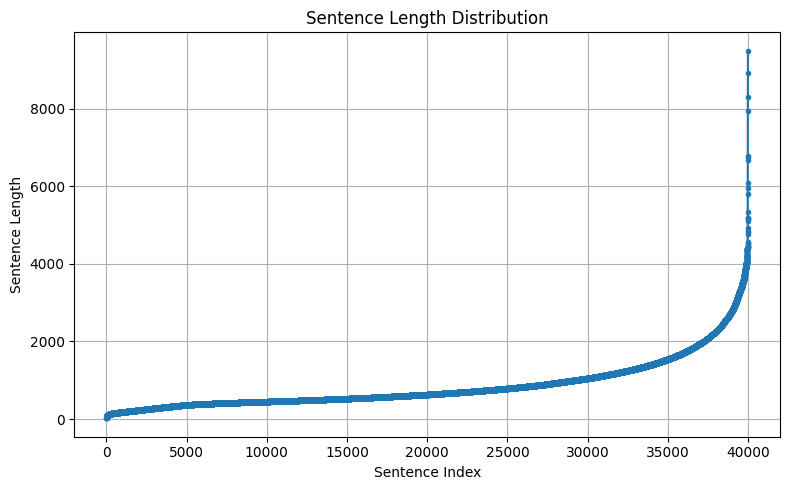

In [ ]:
sentence_lengths = [len(sentence) for sentence in X_train_cleaned]
sorted_lengths = sorted(sentence_lengths)

x_values = list(range(1, len(X_train_cleaned) + 1))

# Creiamo il grafico
plt.figure(figsize=(8, 5))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.show()

### Zoom on the left part

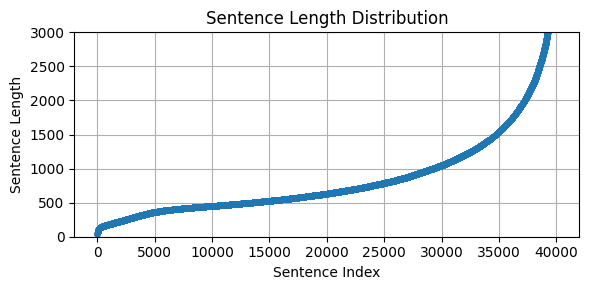

In [ ]:
# Creiamo il grafico
plt.figure(figsize=(6, 3))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 3000)
plt.show()

**most of the sentences have less than 2000 words and 1000 words**

### Check the total set of words

In [ ]:
all_words = [word for sentence in X_train_cleaned for word in sentence.split()]

# Calculate the vocabulary size (number of unique words)
total_vocab_size = len(set(all_words))

print("Total Vocabulary Size:", total_vocab_size)

Total Vocabulary Size: 109842


### Tokenization

In [ ]:
vocab_size = 50000
max_length = 2000
trunc_type='post'
padding_type='post'
oov_tok = ""

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_cleaned)

In [ ]:
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train_cleaned)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### WordCloud

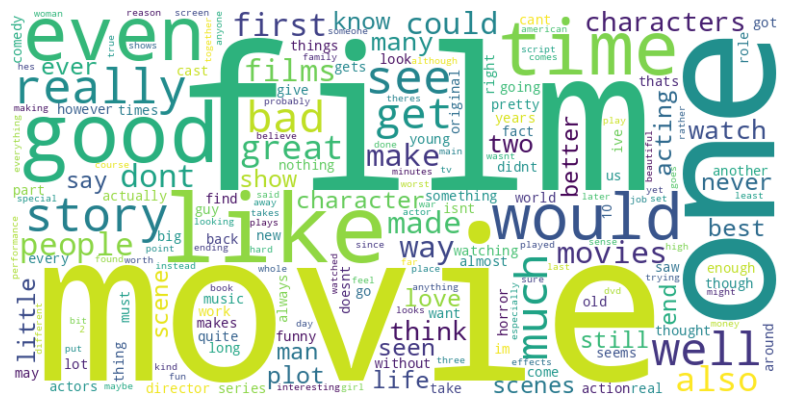

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
word_counts = tokenizer.word_counts
wordcloud.generate_from_frequencies(word_counts)
wordcloud.to_file("header.png")

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

seems we have done a good cleaning

### Split the train into train and validation
Using 80% for train and 20% for test

In [ ]:
training_padded, validation_padded, y_train, y_valid = train_test_split(training_padded, y_train, test_size=0.2, random_state=2023)

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(y_train)

validation_padded = np.array(validation_padded)
validation_labels = np.array(y_valid)

testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

In [ ]:
print(f'Train shappe: {train_data.shape}')
print(f'Validation shappe: {validation_padded.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 2)
Validation shappe: (8000, 2000)
Test shappe: (10000, 2)


### Define the neural network

In [ ]:
embedding_dim = round(vocab_size ** 0.25) # use the fourth root of the vocab size
l2_regularization = 0.01 # tends to amplify differences between nonzero values and zero or close-tozero ones

In [ ]:
def create_model(vocab_size, embedding_dim, max_length):
    input_layer = tf.keras.layers.Input(shape=(max_length,))

    embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

    # 🔥 More powerful feature extraction
    conv_layer = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(embedding_layer)
    pooled_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

    batch_norm_1 = tf.keras.layers.BatchNormalization()(pooled_layer)

    dense_layer_1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(batch_norm_1)
    dropout_layer_1 = tf.keras.layers.Dropout(0.5)(dense_layer_1)  # 🔥 Increase dropout

    dense_layer_2 = tf.keras.layers.Dense(64, activation='relu')(dropout_layer_1)
    batch_norm_2 = tf.keras.layers.BatchNormalization()(dense_layer_2)

    dropout_layer_2 = tf.keras.layers.Dropout(0.4)(batch_norm_2)

    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer_2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    adam = tf.keras.optimizers.Adam(learning_rate=0.001)  # 🔥 Higher LR
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
model = create_model(vocab_size, embedding_dim, max_length)
# Display the model's architecture
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_8 (Embedding)              │ (None, 2000, 15)            │         750,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 2000, 64)            │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 772,017 (2.95 MB)

 Trainable params: 771,761 (2.94 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
checkpoint_path = "training/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq=5  # Save every 5 epochs
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(training_labels), y=training_labels)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
history = model.fit(
    training_padded,
    training_labels,
    epochs=2,
    validation_data=(validation_padded, validation_labels),
    class_weight=class_weights_dict,
    verbose=2
)

Epoch 1/10
1000/1000 - 107s - 107ms/step - accuracy: 0.6873 - loss: 0.9583 - val_accuracy: 0.8461 - val_loss: 0.4357
Epoch 2/10
1000/1000 - 139s - 139ms/step - accuracy: 0.8949 - loss: 0.3075 - val_accuracy: 0.8764 - val_loss: 0.3177
Epoch 3/10


KeyboardInterrupt: 

### Save the entire model

In [ ]:
model.save('model/sentiment_model_v1')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=model/sentiment_model_v1.

### Plot accuracy and loss during training

In [ ]:
def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()

In [ ]:
plot_history(history, "accuracy")
plot_history(history, "loss")

NameError: name 'history' is not defined

### Evaluate the model

In [ ]:
model.evaluate(testing_padded, testing_labels, verbose=2)

313/313 - 8s - 25ms/step - accuracy: 0.8121 - loss: 0.4862


[0.4862287938594818, 0.8120999932289124]

### Make predictions

In [ ]:
sentences = ["I recently watched it, and it's absolutely fantastic. The acting, direction, and storytelling are all top-notch. I highly recommend it.",
             "I watched it and was let down. The acting felt flat, and the story was uninspiring. I wouldn't recommend it."]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

seems to work

### Visualizing the Embeddings

To visualize the embeddings we use this tool: https://projector.tensorflow.org/

This tool requires 2 inpiut file:
    
    * TSV file for the vectors
    * TSV file for metadata (optional)

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]

In [ ]:
out_v = io.open('data/vector.tsv', 'w', encoding='utf-8')
out_m = io.open('data/metadata.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

### This is the result for the embedding

![Embedding](doc/Embedding.png)